In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
Features=pd.read_csv("../data/data_proccesed.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

#Y -= 1

# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [4]:
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.02))
scheduler = LearningRateScheduler(custom_scheduler)

normalizer = layers.Normalization()
normalizer.adapt(X)

k=6
model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)), 
    normalizer,
    layers.Reshape((x_train.shape[1], 1)), 
    layers.Conv1D(2**(k+4), 1, activation='relu'),
    layers.Conv1D(2**(k+3), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k+2), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(2**(k+4), activation='relu'),
    layers.Dense(9, activation='softmax'),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [5]:
history=model.fit(x_train, y_train, epochs=80, batch_size=32, validation_data=(x_test, y_test),callbacks=scheduler)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 63s 181ms/step - accuracy: 0.5745 - loss: 1.2133 - val_accuracy: 0.7182 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 57s 166ms/step - accuracy: 0.7626 - loss: 0.6248 - val_accuracy: 0.7205 - val_loss: 0.7215 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 66s 195ms/step - accuracy: 0.7682 - loss: 0.6054 - val_accuracy: 0.7559 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 90s 263ms/step - accuracy: 0.7917 - loss: 0.5378 - val_accuracy: 0.7311 - val_loss: 0.7011 - learning_rate: 0.0010
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 73s 215ms/step - accuracy: 0.7816 - loss: 0.5634 - val_accuracy: 0.7630 - val_loss: 0.6549 - learning_rate: 0.0010
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 90s 264ms/step - accuracy: 0.8079 - loss: 0.4930 - val_accuracy: 0.7264 - val_loss: 0.7109 - learning_rate: 0.0010
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 267s 787ms/step - accur

In [10]:
model.evaluate(x_test,y_test)
model.save(r"../model/model.h5")

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.7931 - loss: 2.6172


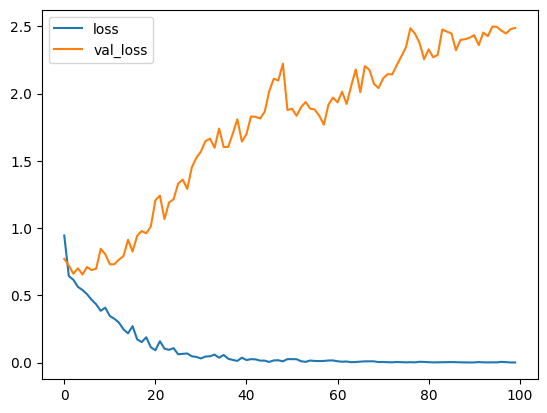

In [11]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Test set accuracy: 79%


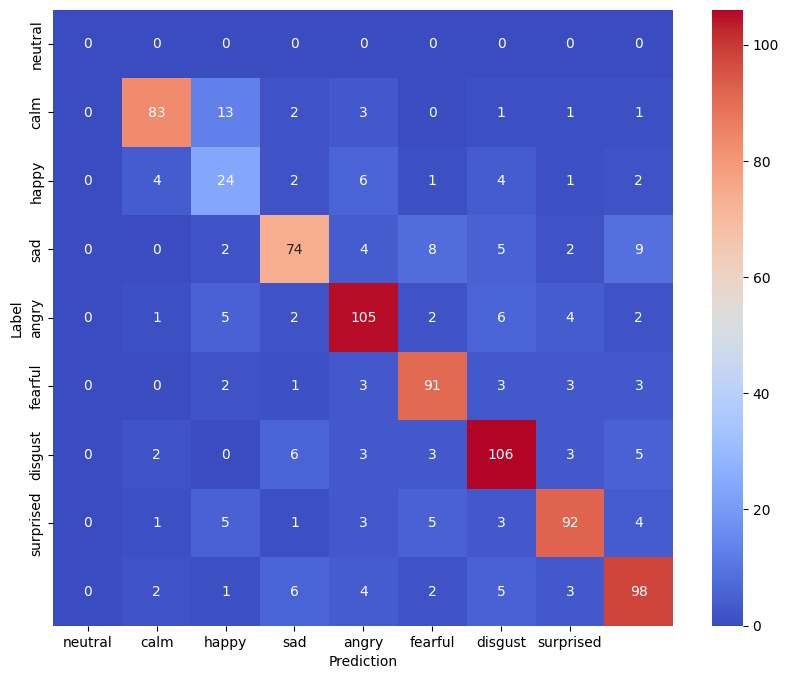

In [12]:
commands=["neutral","calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [13]:
model.evaluate(x_test,y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7931 - loss: 2.6172


[2.4885005950927734, 0.7936320900917053]